In [3]:
# まず、とあるECoGチャンネル予測を全EEG LSTMで学習
# 学習後LSTMを使って全EEG チャンネルを予測
# これを繰り返す

In [68]:
# -*- coding: utf_8 -*-  
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

import copy
import json
import pandas as pd
import numpy as np
import datetime
import math
import time


from keras.models import Model, Sequential
from keras.layers import Dense, Activation, recurrent, Input, Embedding
from keras.preprocessing.sequence import pad_sequences

from scipy import signal


import pickle
import sys
import random
import h5py


In [69]:
EEG2 = pad_sequences(EEG, 10)

In [70]:
EEG2.shape

(300000, 10)

In [2]:
test=h5py.File('Ma/DeepANES.mat')

ECoG = np.array(test['ECoG'])
EEG = np.array(test['EEG'])
EEG = np.delete(EEG, 14, axis=1)
EEG = EEG.astype('float32')
ECoG = ECoG.astype('float32')

In [76]:
#sample, window_size(timesteps), channel に変換する
# 1000sample, 1000msec, channle?
# sample は10msずつずらして水増し

samples = 100
timesteps = 1000
overlap = 10

ECoG_t = np.zeros((samples, timesteps, ECoG.shape[1]))
EEG_t = np.zeros((samples, timesteps, EEG.shape[1]))
for t in range(samples):
    t0 = t*overlap
    t1 = t0+timesteps
    for ch_ecog in range(ECoG.shape[1]):
        ECoG_t[:, :, ch_ecog] = ECoG[t0:t1, ch_ecog]
    for ch_eeg in range(EEG.shape[1]):
        EEG_t[:, :, ch_eeg] = EEG[t0:t1, ch_eeg]

In [100]:


input_cs=256
output_cs=16

#x1 = Embedding(input_dim=input_cs, output_dim=10, mask_zero=True)
rnn1 = recurrent.SimpleRNN(units=output_cs, activation='linear', input_shape=(None, input_cs),return_sequences=True)

model = Sequential()
#model.add(x1)
model.add(rnn1)
#model.add(Dense(output_dim=output_cs,input_dim=input_cs))

model.compile(optimizer='adadelta',
              loss='mse',
              metrics=['mse'])

In [101]:
a = model.fit(ECoG_t, EEG_t,epochs=10,
          batch_size=16,verbose=0)

Epoch 1/10
100/100 [==============================] - 3s - loss: 279177408.6400 - mean_squared_error: 279177412.4800     
Epoch 2/10
100/100 [==============================] - 3s - loss: 132444660.4800 - mean_squared_error: 132444733.4400     

In [102]:
model_old = model
model_old.get_output_at(0)

<tf.Tensor 'simple_rnn_71/transpose_1:0' shape=(?, ?, 16) dtype=float32>

In [103]:

input_cs=16
output_cs=256

rnn1 = recurrent.SimpleRNN(units=output_cs, activation='linear', input_shape=(None, input_cs),return_sequences=True)
model = Sequential()
model.add(rnn1)

model.compile(optimizer='adadelta',
              loss='mse',
              metrics=['mse'])

In [114]:
preditcted_EEG = model_old.predict(ECoG_t)

In [115]:
a = model.fit(preditcted_EEG, ECoG_t,epochs=10,
          batch_size=16)

Epoch 1/10
100/100 [==============================] - 5s - loss: 2663163720.1600 - mean_squared_error: 2663166366.5600       
Epoch 2/10
100/100 [==============================] - 5s - loss: 50532759.5200 - mean_squared_error: 50532751.8400     

In [135]:
def makeRNN(input_cs, output_cs):
    rnn1 = recurrent.SimpleRNN(units=output_cs, activation='linear', input_shape=(None, input_cs),return_sequences=True)
    model = Sequential()
    model.add(rnn1)
    model.compile(optimizer='adadelta',
                  loss='mse',
                  metrics=['mse'])
    return model

n_loop =30
epochs = 100

#preditcted_EEGfromECoG = ECoG_t
preditcted_EEGfromEEG = EEG_t

st = time.time()

models_EEG = []
models_ECoG = []
for n in range(n_loop):
    # ECoG->EEG
    mec = makeRNN(256,16)
    loss = mec.fit(ECoG_t, preditcted_EEGfromEEG,epochs=epochs,
          batch_size=16,verbose=0)
    preditcted_EEGfromECoG = mec.predict(ECoG_t)
    # EEG -> ECoG
    mee = makeRNN(16,16)
    loss = mee.fit(preditcted_EEGfromEEG, preditcted_EEGfromECoG,epochs=epochs,
          batch_size=16,verbose=0)
    preditcted_EEGfromEEG = mee.predict(preditcted_EEGfromEEG)
    models_EEG.append(mee)
    models_ECoG.append(mec)
    print("{0}: {1} msec".format(n,time.time()-st))
    


0: 555.392492055893 msec
1: 1098.1877701282501 msec
2: 1657.7480812072754 msec
3: 2217.1408240795135 msec
4: 2771.0818359851837 msec
5: 3321.598354101181 msec
6: 3878.8605768680573 msec
7: 4433.670253992081 msec
8: 5005.932471036911 msec
9: 5566.335796833038 msec
10: 6125.91262793541 msec
11: 6688.073497056961 msec
12: 7247.664644002914 msec
13: 7800.893229007721 msec
14: 8352.998100042343 msec
15: 8912.895829916 msec
16: 9483.20412683487 msec
17: 10049.085381031036 msec
18: 10608.993807077408 msec
19: 11169.983412027359 msec
20: 11731.379651069641 msec
21: 12292.803203105927 msec
22: 12854.794919967651 msec
23: 13419.954610824585 msec
24: 13981.59119796753 msec
25: 14543.693134069443 msec
26: 15101.94834804535 msec
27: 15667.334469079971 msec
28: 16227.684116840363 msec
29: 16794.07062125206 msec


In [136]:
loss.history

{'loss': [271810.85187499999,
  146084.02812500001,
  127636.281875,
  116783.7775,
  109057.8575,
  103001.575625,
  97968.018437499995,
  93618.545624999999,
  89756.543124999997,
  86259.532812499994,
  83047.521875000006,
  80066.466562500005,
  77279.133124999993,
  74659.696249999994,
  72189.821562500001,
  69856.512187500004,
  67650.304062499999,
  65564.128437499996,
  63592.455937500003,
  61730.877031249998,
  59975.673281249998,
  58323.462031249997,
  56770.975156250002,
  55314.797031249997,
  53951.230000000003,
  52676.223749999997,
  51485.44171875,
  50374.31671875,
  49338.141718749997,
  48372.210781250003,
  47471.833906250002,
  46632.4921875,
  45849.825781250001,
  45119.708906250002,
  44438.255624999998,
  43801.854218749999,
  43207.131562499999,
  42650.984375,
  42130.518593749999,
  41643.063125000001,
  41186.12859375,
  40757.392500000002,
  40354.716718750002,
  39976.130156250001,
  39619.835312499999,
  39284.185624999998,
  38967.684999999998,
  386

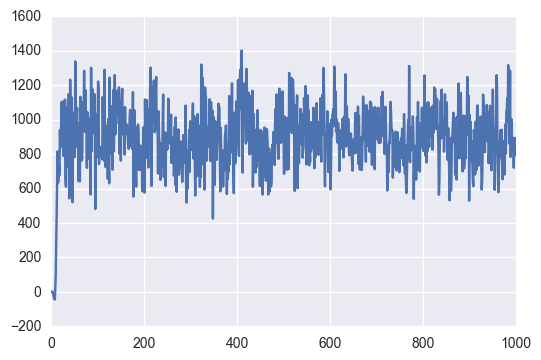

In [139]:
plt.plot(preditcted_ECoG[0,:,1])

In [132]:
#sample, window_size(timesteps), channel に変換する
# 1000sample, 1000msec, channle?
# sample は10msずつずらして水増し

samples = 100
timesteps = 1000
overlap = 10

move = 10000

ECoG_t2 = np.zeros((samples, timesteps, ECoG.shape[1]))
EEG_t2 = np.zeros((samples, timesteps, EEG.shape[1]))
for t in range(samples):
    t0 = t*overlap+move
    t1 = t0+timesteps
    for ch_ecog in range(ECoG.shape[1]):
        ECoG_t2[:, :, ch_ecog] = ECoG[t0:t1, ch_ecog]
    for ch_eeg in range(EEG.shape[1]):
        EEG_t2[:, :, ch_eeg] = EEG[t0:t1, ch_eeg]

In [ ]:
for m_EEG in models_EEG:
    p_EEG2 = m_EEG.predict()

input_cs=256
output_cs=16

x_input = Input(shape=(input_cs,), dtype='float32')
x1 = Embedding(input_dim=input_cs, output_dim=16, mask_zero=True)(x_input)

rnn1 = recurrent.SimpleRNN(units=input_cs, activation='linear',return_sequences=True)(x1)
rnn2 = recurrent.SimpleRNN(units=input_cs, activation='linear',return_sequences=True)(rnn1+x_input)
rnn3 = recurrent.SimpleRNN(units=input_cs, activation='linear',return_sequences=True)(rnn2+x_input)
rnn4 = recurrent.SimpleRNN(units=input_cs, activation='linear',return_sequences=True)(rnn3+x_input)
rnn5 = recurrent.SimpleRNN(units=input_cs, activation='linear',return_sequences=True)(rnn4+x_input)
rnn6 = recurrent.SimpleRNN(units=input_cs, activation='linear',return_sequences=True)(rnn4+x_input)
rnn7 = recurrent.SimpleRNN(units=input_cs, activation='linear',return_sequences=True)(rnn4+x_input)
rnn8 = recurrent.SimpleRNN(units=input_cs, activation='linear')(rnn4+x_input)

model = Model(inputs=x_input, outputs=rnn8)